In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing  
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from pprint import pprint
from sklearn.metrics import accuracy_score

In [3]:
import copy as cp

In [4]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


In [293]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [294]:
def cross_val_predict(model, kfold, X , y):

    model = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 
    total_acc = []
    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X.loc[train_ndx], y[train_ndx], X.loc[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model.predict(test_X))
        total_acc.append(accuracy_score(actual_classes,predicted_classes))
        

    return actual_classes, predicted_classes, round(np.mean(total_acc),2),model

In [295]:
def plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [296]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [297]:
def plot_cross_val_roc(kfold,clfs,X,y):

  # Run classifier with cross-validation and plot ROC curves
  for clf in clfs:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(kfold.split(X, y)):
        clf.fit(X.loc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            clf,
            X.loc[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

In [298]:
# y = df_ln[label_ln]
# X = preprocessing.scale(X)

In [299]:
# for i, (train, test) in enumerate(kfold.split(X, y)):
#   print([i,(train, test)])
#   print(X.iloc[train],y.iloc[train])

In [300]:
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}

# Labor Negotiation Data

In [7]:
ln_col = ['dur','wage1','wage2','wage3',
          'cola','hrs','pension','stby_pay',
          'shift_diff','educ_allw','holidays','vacation',
          'Ingtrm_disabi','dntl_ins','bereavement','empl_hplan','good/bad']

In [8]:
df_ln_train = pd.read_csv('/content/drive/My Drive/5155-hw2/labor-neg.data.csv',names = ln_col)

In [9]:
df_ln_test = pd.read_csv('/content/drive/My Drive/5155-hw2/labor-neg.test.csv',names = ln_col)

In [10]:
df_ln = pd.concat([df_ln_train,df_ln_test])
df_ln

,dur,wage1,wage2,wage3,cola,hrs,pension,stby_pay,shift_diff,educ_allw,holidays,vacation,Ingtrm_disabi,dntl_ins,bereavement,empl_hplan,good/bad
0,1,5.0,?,?,?,40,?,?,2,?,11,average,?,?,yes,?,good
1,2,4.5,5.8,?,?,35,ret_allw,?,?,yes,11,below average,?,full,?,full,good
2,?,?,?,?,?,38,empl_contr,?,5,?,11,generous,yes,half,yes,half,good
3,3,3.7,4.0,5.0,tc,?,?,?,?,yes,?,?,?,?,yes,?,good
4,3,4.5,4.5,5.0,?,40,?,?,?,?,12,average,?,half,yes,half,good
5,2,2.0,2.5,?,?,35,?,?,6,yes,12,average,?,?,?,?,good
6,3,4.0,5.0,5.0,tc,?,empl_contr,?,?,?,12,generous,yes,none,yes,half,good
7,3,6.9,4.8,2.3,?,40,?,?,3,?,12,below average,?,?,?,?,good
8,2,3.0,7.0,?,?,38,?,12,25,yes,11,below average,yes,half,yes,?,good
9,1,5.7,?,?,none,40,empl_contr,?,4,?,11,generous,yes,full,?,?,good


In [11]:
for i in ln_col:
  print(df_ln[i].dtypes)
  # df_ln[i].plot(kind = 'hist',edgecolor = 'black')

object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object


# Data Preprocessing

In [12]:
float_col = ['dur','wage1','wage2','wage3','hrs','stby_pay','shift_diff','holidays']

In [13]:
for i in float_col:
  df_ln[i] = df_ln[i].replace("?"," ")
  df_ln[i] = pd.to_numeric(df_ln[i],errors = 'coerce')
  # df_ln[i] = df_ln[i].astype('float')

In [14]:
for i in float_col:
  df_ln[i] = df_ln[i].fillna(df_ln[i].mean())

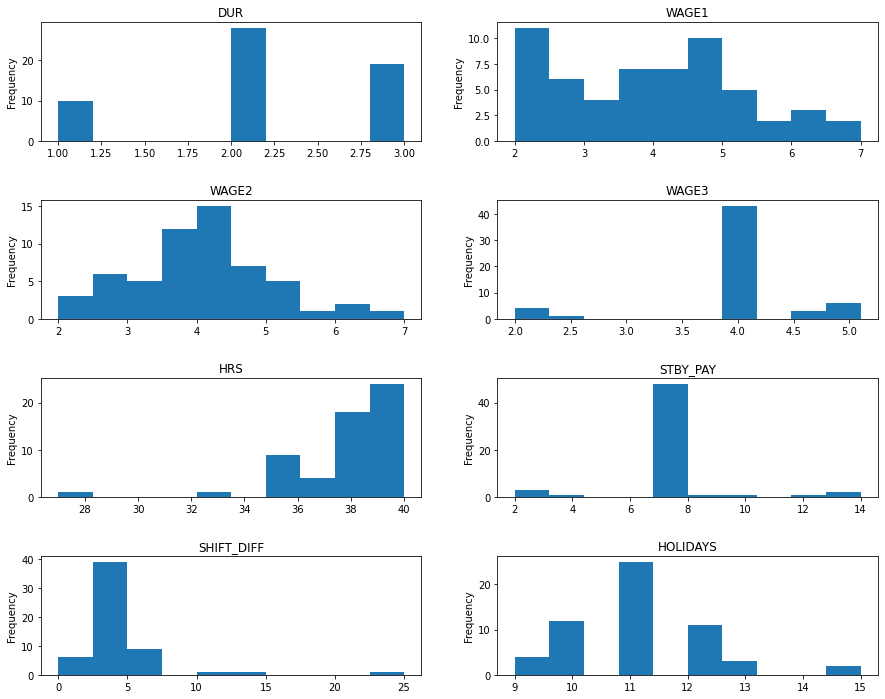

In [15]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
for i,ax in zip(float_col,axs.ravel()):
  df_ln[i].plot(ax=ax,kind = 'hist')
  ax.set_title(i.upper())

In [16]:
df_ln.loc[:,['dur','wage1','wage2','wage3','hrs','stby_pay','shift_diff','holidays']] = preprocessing.scale(df_ln.loc[:,['dur','wage1','wage2','wage3','hrs','stby_pay','shift_diff','holidays']])

In [17]:
string_col = ['cola','pension','educ_allw','vacation','Ingtrm_disabi','dntl_ins','bereavement','empl_hplan']

In [18]:
for i in string_col:
  df_ln[i] = df_ln[i].replace("?"," ")
  df_ln[i] = df_ln[i].astype('str')

In [19]:
def categorical_impute(df,col):
  freq = {}
  for i in df_ln[col]:
    if i == " ":
      continue
    if i not in freq:
      freq[i] = 1
    else:
      freq[i] += 1

  max = 0
  max_key = 0
  for k,v in freq.items():
    if max < v:
      max = v
      max_key = k
  # print(max_key)
  df_ln[col] = df_ln[col].replace(" ",max_key)

In [20]:
for i in string_col:
  categorical_impute(df_ln,i)

In [21]:
df_ln = df_ln.reset_index()

In [22]:
df_ln.drop('index',axis = 1,inplace = True)

In [23]:
dummies = pd.get_dummies(df_ln[string_col])

In [24]:
merged = pd.concat([df_ln,dummies],axis = 'columns')

In [25]:
df_ln_final = merged.drop(string_col,axis = 'columns')

In [26]:
df_ln_final

,dur,wage1,wage2,wage3,hrs,stby_pay,shift_diff,holidays,good/bad,cola_none,...,Ingtrm_disabi_no,Ingtrm_disabi_yes,dntl_ins_full,dntl_ins_half,dntl_ins_none,bereavement_no,bereavement_yes,empl_hplan_full,empl_hplan_half,empl_hplan_none
0,-1.669452,0.888656,0.000000,0.000000,8.355197e-01,4.715451e-16,-0.870865,-0.078403,good,1,...,0,1,0,1,0,0,1,1,0,0
1,-0.231155,0.517277,1.767689,0.000000,-1.295055e+00,4.715451e-16,0.000000,-0.078403,good,1,...,0,1,1,0,0,0,1,1,0,0
2,0.000000,0.000000,0.000000,0.000000,-1.671039e-02,4.715451e-16,0.039140,-0.078403,good,1,...,0,1,0,1,0,0,1,0,1,0
3,1.207142,-0.076928,0.027325,1.681075,3.027729e-15,4.715451e-16,0.000000,0.000000,good,0,...,0,1,0,1,0,0,1,1,0,0
4,1.207142,0.517277,0.510759,1.681075,8.355197e-01,4.715451e-16,0.000000,0.752664,good,1,...,0,1,0,1,0,0,1,0,1,0
5,-0.231155,-1.339615,-1.422979,0.000000,-1.295055e+00,4.715451e-16,0.342475,0.752664,good,1,...,0,1,0,1,0,0,1,1,0,0
6,1.207142,0.145899,0.994194,1.681075,3.027729e-15,4.715451e-16,0.000000,0.752664,good,0,...,0,1,0,0,1,0,1,0,1,0
7,1.207142,2.299894,0.800820,-2.495830,8.355197e-01,4.715451e-16,-0.567530,0.752664,good,1,...,0,1,0,1,0,0,1,1,0,0
8,-0.231155,-0.596858,2.927932,0.000000,-1.671039e-02,2.418602e+00,6.105839,-0.078403,good,1,...,0,1,0,1,0,0,1,1,0,0
9,-1.669452,1.408586,0.000000,0.000000,8.355197e-01,4.715451e-16,-0.264195,-0.078403,good,1,...,0,1,1,0,0,0,1,1,0,0


In [320]:
X = df_ln_final.drop('good/bad',axis = 1)

In [321]:
y = df_ln_final['good/bad']

In [322]:
label_ln = ['good/bad']

# Check Correlation

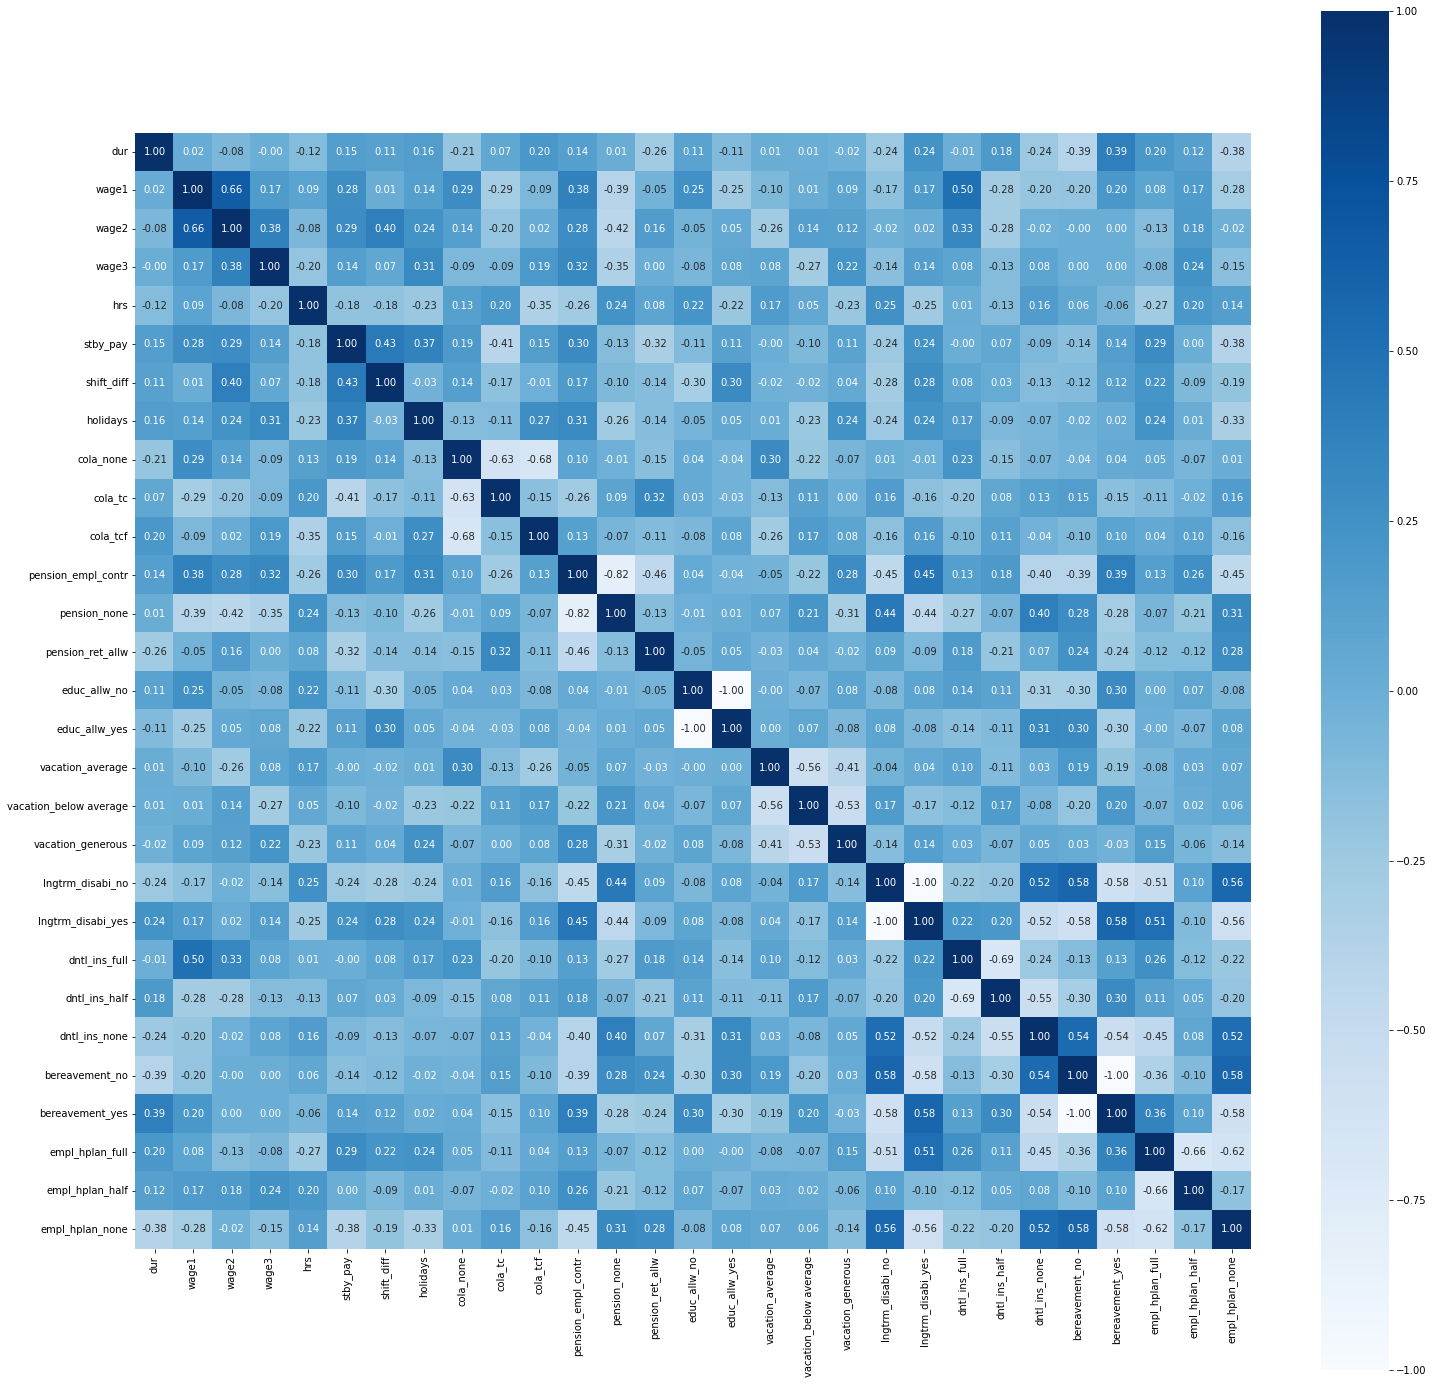

In [323]:
plt.figure(figsize = (25,25))
corr_values_ln = X.corr() 
sns.heatmap(corr_values_ln, annot=True,vmax=1, square=True, cmap="Blues",fmt='.2f')

In [324]:
upper_tri = corr_values_ln.where(np.triu(np.ones(corr_values_ln.shape),k=1).astype(np.bool))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [325]:
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.6)]

In [326]:
to_drop

['wage2',
 'cola_tc',
 'cola_tcf',
 'pension_none',
 'educ_allw_yes',
 'Ingtrm_disabi_yes',
 'dntl_ins_half',
 'bereavement_yes',
 'empl_hplan_half',
 'empl_hplan_none']

In [327]:
X = X.drop(X[to_drop],axis=1)

In [328]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Gradient Boosting Hyperparameter Tuning

In [329]:
# Number of trees in gradient boost
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [330]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 5, cv=10,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [331]:
pprint(gb_random.best_params_)

{'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200}


# MLP Hyperparameter Tuning

In [332]:
solver = ['lbfgs']
max_iter = [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
alpha = 10.0 ** -np.arange(1, 10)
hidden_layer_sizes = np.arange(10,100)

In [333]:
mlp_parameters = {'solver': solver, 'max_iter': max_iter, 'alpha': alpha, 'hidden_layer_sizes':hidden_layer_sizes}

In [334]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
mlp = MLPClassifier()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_parameters, n_iter = 5, cv=10,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
mlp_random.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10, estimator=MLPClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                                        'hidden_layer_sizes': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99]),
                                        'max_iter': [1000, 1100, 1200, 1300,
                                                     1400, 1500, 1600, 1700,
                                                     1800, 1900, 2000],
                                        'solver': ['lbfgs']},
                   random_state=42,

In [335]:
pprint(mlp_random.best_params_)

{'alpha': 0.1, 'hidden_layer_sizes': 88, 'max_iter': 1200, 'solver': 'lbfgs'}


In [336]:
def fredman_rank(fredman):
  keys = list(fredman.keys())
  values = list(fredman.values())

  fredman_rank = {}
  for i in keys:
    fredman_rank[i] = 1
  
  max = 0
  for i,j in zip(range(len(values)),range(len(keys))):
    a = values[:i] + values[i+1:]
    for k in a:
      if k > values[i]:
        fredman_rank[keys[j]] += 1
  return fredman_rank

In [337]:
fredman_ln = {}

svm:0.95


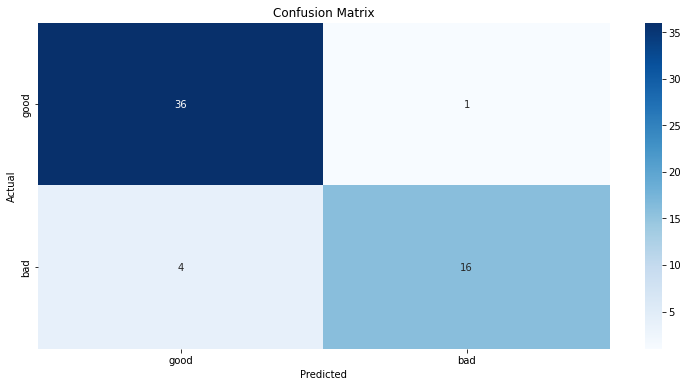

rf:0.84


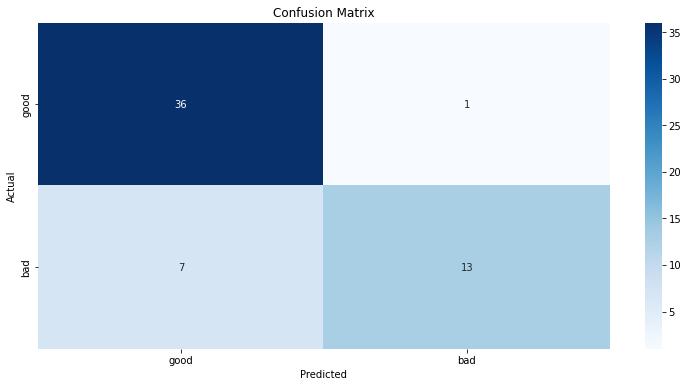

dt:0.87


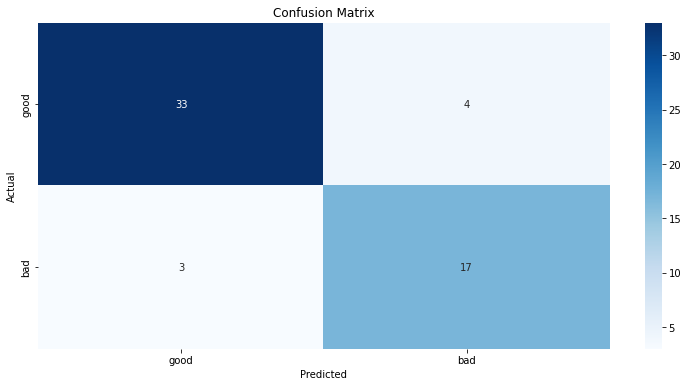

knn:0.92


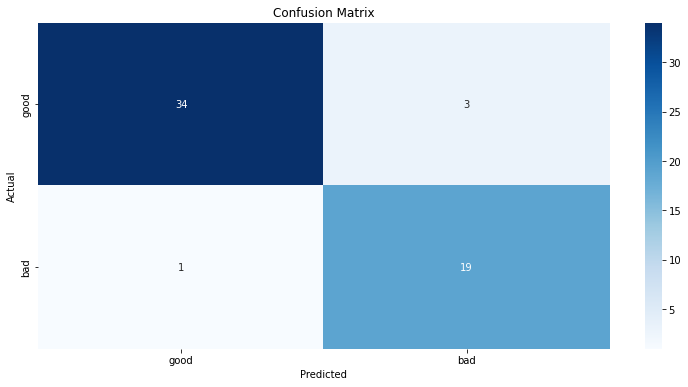

mlp:0.96


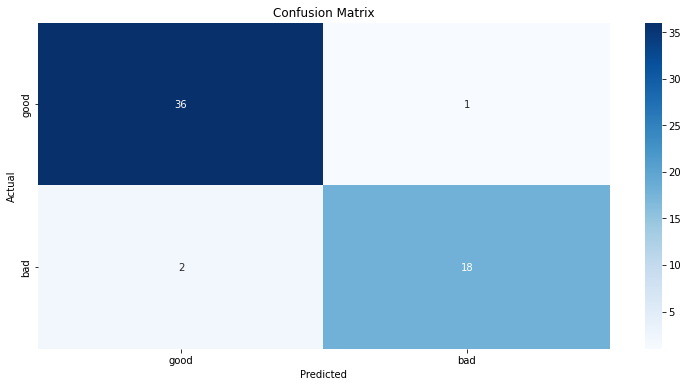

gb:0.82


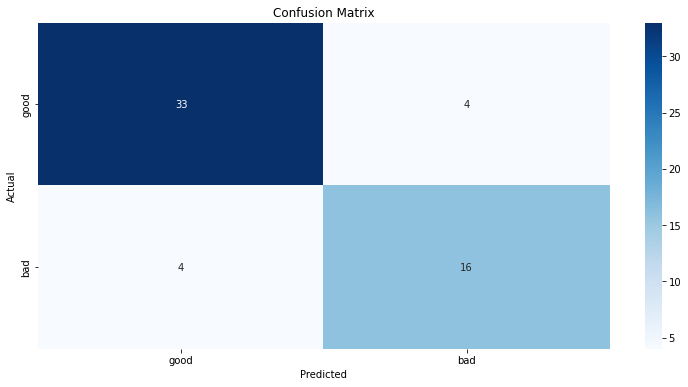

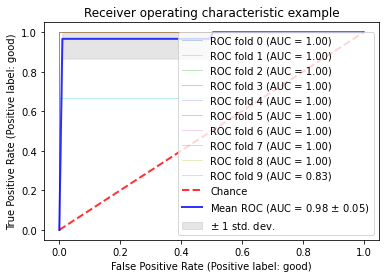

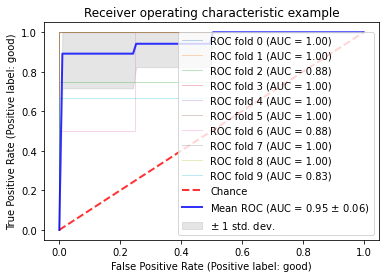

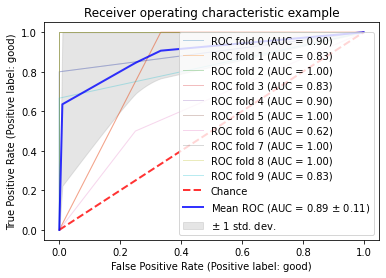

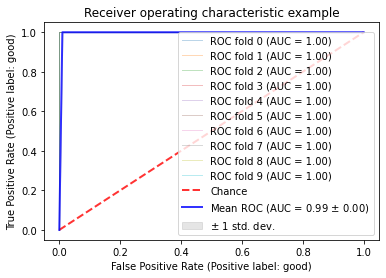

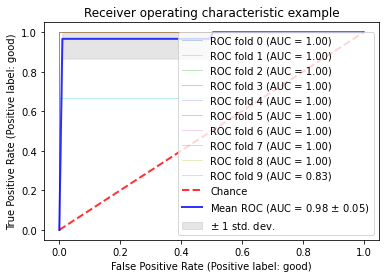

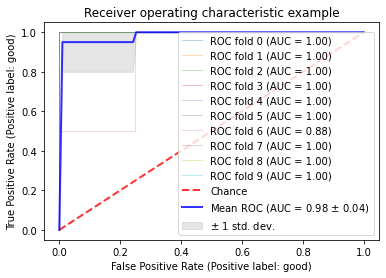

In [338]:
for i in range(len(label_ln)):
  y = df_ln[label_ln[i]]
  X = X

  # x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
  labels = ['good','bad']

  #svm
  svm_clf = SVC(random_state = 42)
  result_svm = cross_val_predict(svm_clf,kfold,X,y)
  print('svm:' + str(result_svm[2]))
  plot_confusion_matrix(result_svm[0], result_svm[1], labels)
  fredman_ln['svm'] = result_svm[2]

  #rf
  rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
  result_rf = cross_val_predict(rf_clf,kfold,X,y)
  print('rf:' + str(result_rf[2]))
  plot_confusion_matrix(result_rf[0], result_rf[1], labels)
  fredman_ln['rf'] = result_rf[2]

  #dt
  dt_clf = DecisionTreeClassifier(random_state=0)
  result_dt = cross_val_predict(dt_clf,kfold,X,y)
  print('dt:' + str(result_dt[2]))
  plot_confusion_matrix(result_dt[0], result_dt[1], labels)
  fredman_ln['dt'] = result_dt[2]
  
  #knn
  knn_clf = KNeighborsClassifier(n_neighbors=3)
  result_knn = cross_val_predict(knn_clf,kfold,X,y)
  print('knn:' + str(result_knn[2]))
  plot_confusion_matrix(result_knn[0], result_knn[1], labels)
  fredman_ln['knn'] = result_knn[2]

  #mlp
  mlp_clf = MLPClassifier(random_state=1, alpha = 1e-06, hidden_layer_sizes = 31, max_iter = 2000, solver = 'lbfgs')
  result_mlp = cross_val_predict(mlp_clf,kfold,X,y)
  print('mlp:' + str(result_mlp[2]))
  plot_confusion_matrix(result_mlp[0], result_mlp[1], labels)
  fredman_ln['mlp'] = result_mlp[2]

  #gb
  gb_clf = GradientBoostingClassifier(learning_rate=0.1, random_state=0,max_depth = 50,max_features = "sqrt",min_samples_leaf = 2,
  min_samples_split = 10,n_estimators = 200)
  result_gb = cross_val_predict(gb_clf,kfold,X,y)
  print('gb:' + str(result_gb[2]))
  plot_confusion_matrix(result_gb[0], result_gb[1], labels)
  fredman_ln['gb'] =result_gb[2]

  #create plots

  clfs = [svm_clf,rf_clf,dt_clf,knn_clf,mlp_clf,gb_clf]
  plot_cross_val_roc(kfold,clfs,X,y)
  

In [339]:
fredman_ln

{'svm': 0.95, 'rf': 0.84, 'dt': 0.87, 'knn': 0.92, 'mlp': 0.96, 'gb': 0.82}

In [340]:
fredman_ln_df = pd.DataFrame([fredman_ln])
fredman_ln_df

,svm,rf,dt,knn,mlp,gb
0,0.95,0.84,0.87,0.92,0.96,0.82


In [341]:
fredman_ln_rank = fredman_rank(fredman_ln)

In [342]:
fredman_ln_rank['dataset'] = 'labor negotiation'

In [343]:
fredman_ln_rank = pd.DataFrame([fredman_ln_rank])
fredman_ln_rank

,svm,rf,dt,knn,mlp,gb,dataset
0,2,5,4,3,1,6,labor negotiation


In [344]:
fredman_ln_df.to_csv('/content/drive/My Drive/5155-hw2/fredman_ln_df.csv',index = None)

In [345]:
fredman_ln_rank.to_csv('/content/drive/My Drive/5155-hw2/fredman_ln_rank.csv',index = None)